# Forcasting sub-project for Kaggle E-commerce Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Cleaning E-commerce Data and Preparing for ARIMA forcasting 

C:\Users\E1cal\AppData\Local\Temp\ipykernel_30048\2390439138.py:26: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



NameError: name 'false' is not defined

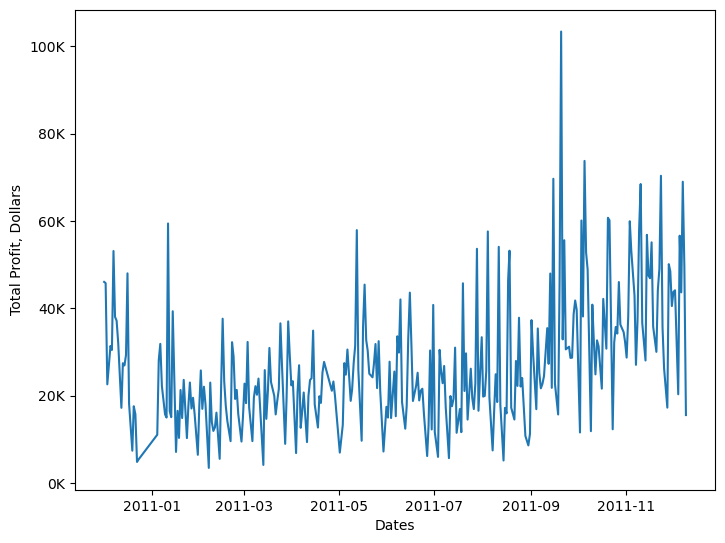

In [30]:
df = pd.read_csv("C:\\Users\\E1cal\\OneDrive\\Documents\\SQL_Notes\\PostgreSQL_Files\\E-commerce_Data\\ordersUTF8.csv")
df = df.dropna()

# df['order_date'] = pd.to_datetime(df['invoice_date']) also directly creates datetime column but need to do more to group by specific unit of time

format_string = "%m/%d/%Y %H:%M"

dt = [datetime.strptime(df_str, format_string) for df_str in df['invoice_date']]

df['month'] = [inv.month for inv in dt]
df['day'] = [inv.day for inv in dt]
df['year'] = [inv.year for inv in dt]
df['date_times'] = dt
df['order_total'] = df['quantity']*df['unit_price']

data_year_month_day = df.groupby(by=['year','month','day'])

total_profit_by_day = data_year_month_day['order_total'].sum().to_numpy()
dates_for_day_sums = data_year_month_day['date_times'].min().to_numpy()

C:\Users\E1cal\AppData\Local\Temp\ipykernel_30048\3111427321.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



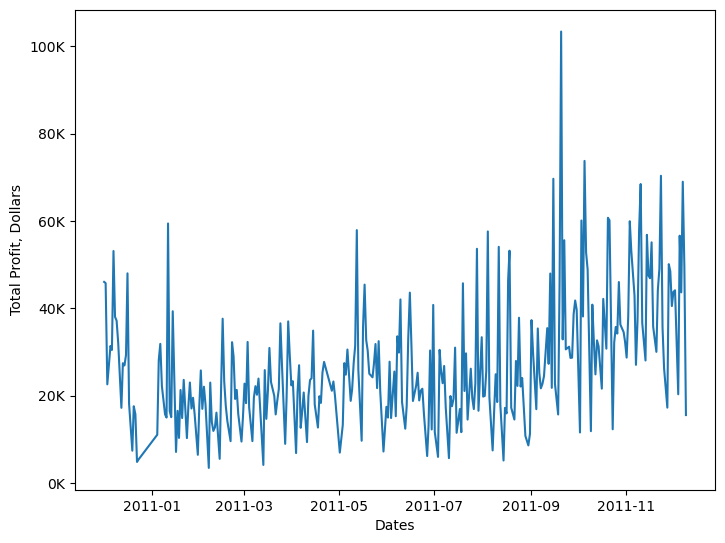

In [56]:
fig = plt.figure()
ax1 = fig.add_axes((0,0,1,1))
plt.plot(dates_for_day_sums, total_profit_by_day*1e-3)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Total Profit, Dollars')
ax1.set_yticklabels([str(int(tk))+'K' for tk in ax1.get_yticks()])
plt.show()
fig.savefig('C:\\Users\\E1cal\\OneDrive\\Documents\\SQL_Notes\\PostgreSQL_Files\\E-commerce_Data\\TotalProfitSeries.png', bbox_inches='tight')

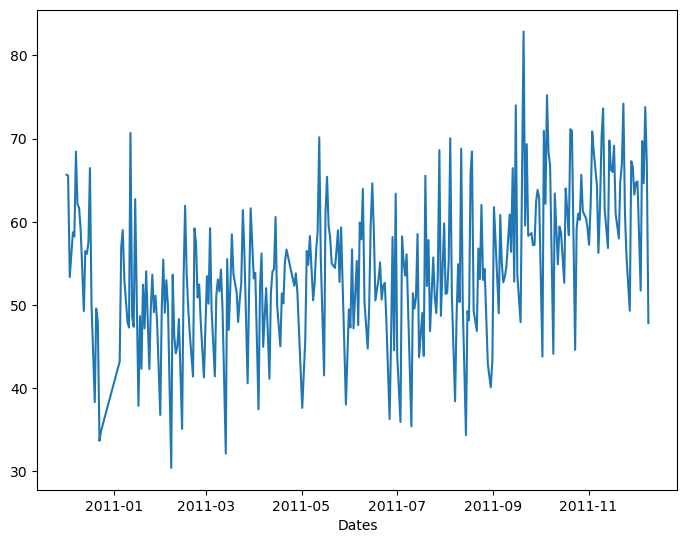

In [58]:
# imposing stationarity on the variance of the data
from scipy.stats import boxcox

day_sum_boxcox, lam = boxcox(total_profit_by_day)

fig = plt.figure()
ax1 = fig.add_axes((0,0,1,1))
plt.plot(dates_for_day_sums, day_sum_boxcox)
ax1.set_xlabel('Dates')
#ax1.set_ylabel('Total Profit, Dollars')
#ax1.set_yticklabels([str(int(tk))+'K' for tk in ax1.get_yticks()])
plt.show()
fig.savefig('C:\\Users\\E1cal\\OneDrive\\Documents\\SQL_Notes\\PostgreSQL_Files\\E-commerce_Data\\BoxcoxSeries.png', bbox_inches='tight')

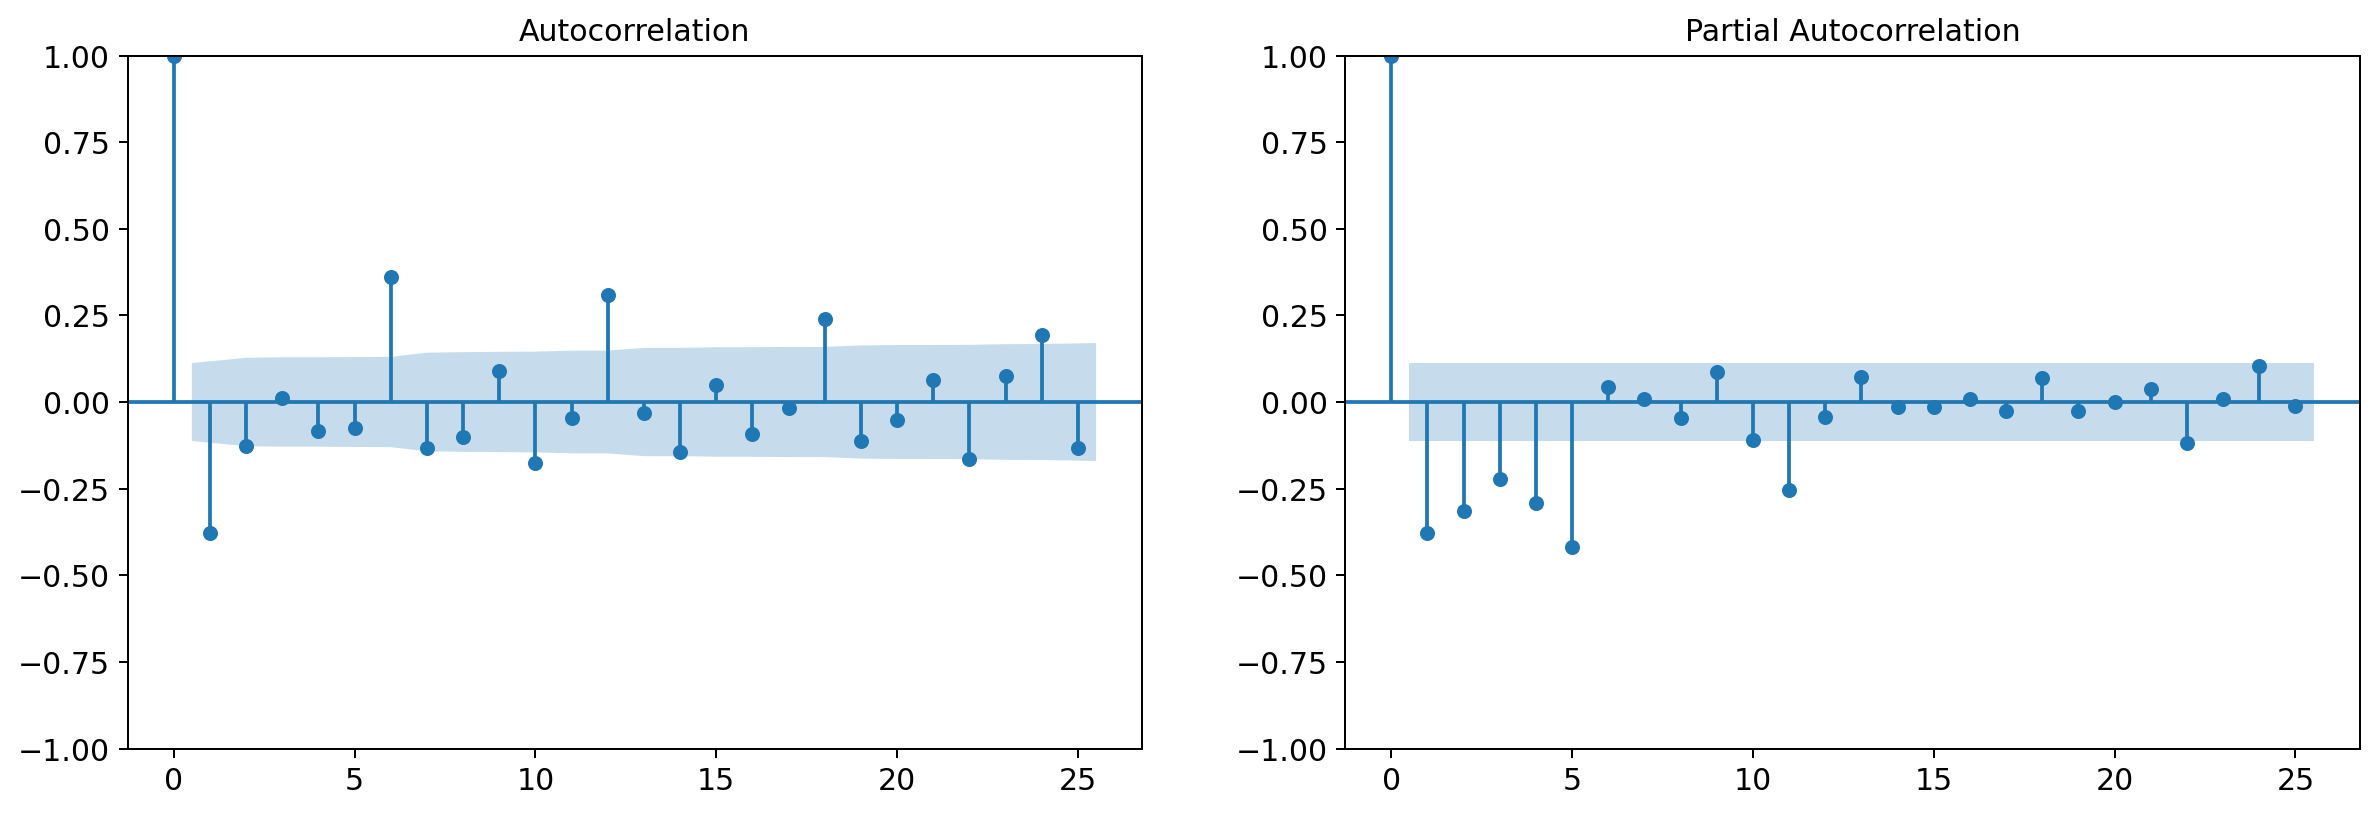

In [8]:
# imposing statinarity in mean and plotting PACF and ACF to estimate orders of AR and MA model componenets

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
# day_sum_diff = np.diff(day_sum_boxcox)

idx = -int(len(total_profit_by_day)*0.2)
# train = day_sum_boxcox[:idx_train]
# test = day_sum_boxcox[idx_test:]
train = day_sum_boxcox[:idx]
test = day_sum_boxcox[idx:]

day_sum_diff = np.diff(day_sum_boxcox)
adf_res = adfuller(day_sum_diff)

# more robust/objective method for deterimining the p and q orders of the AR and MA model components
# arima = pm.auto_arima(train, error_action='ignore', trace=True, 
#                       suppress_warnings=True, maxiter=10,
#                       seasonal=False, m=1)


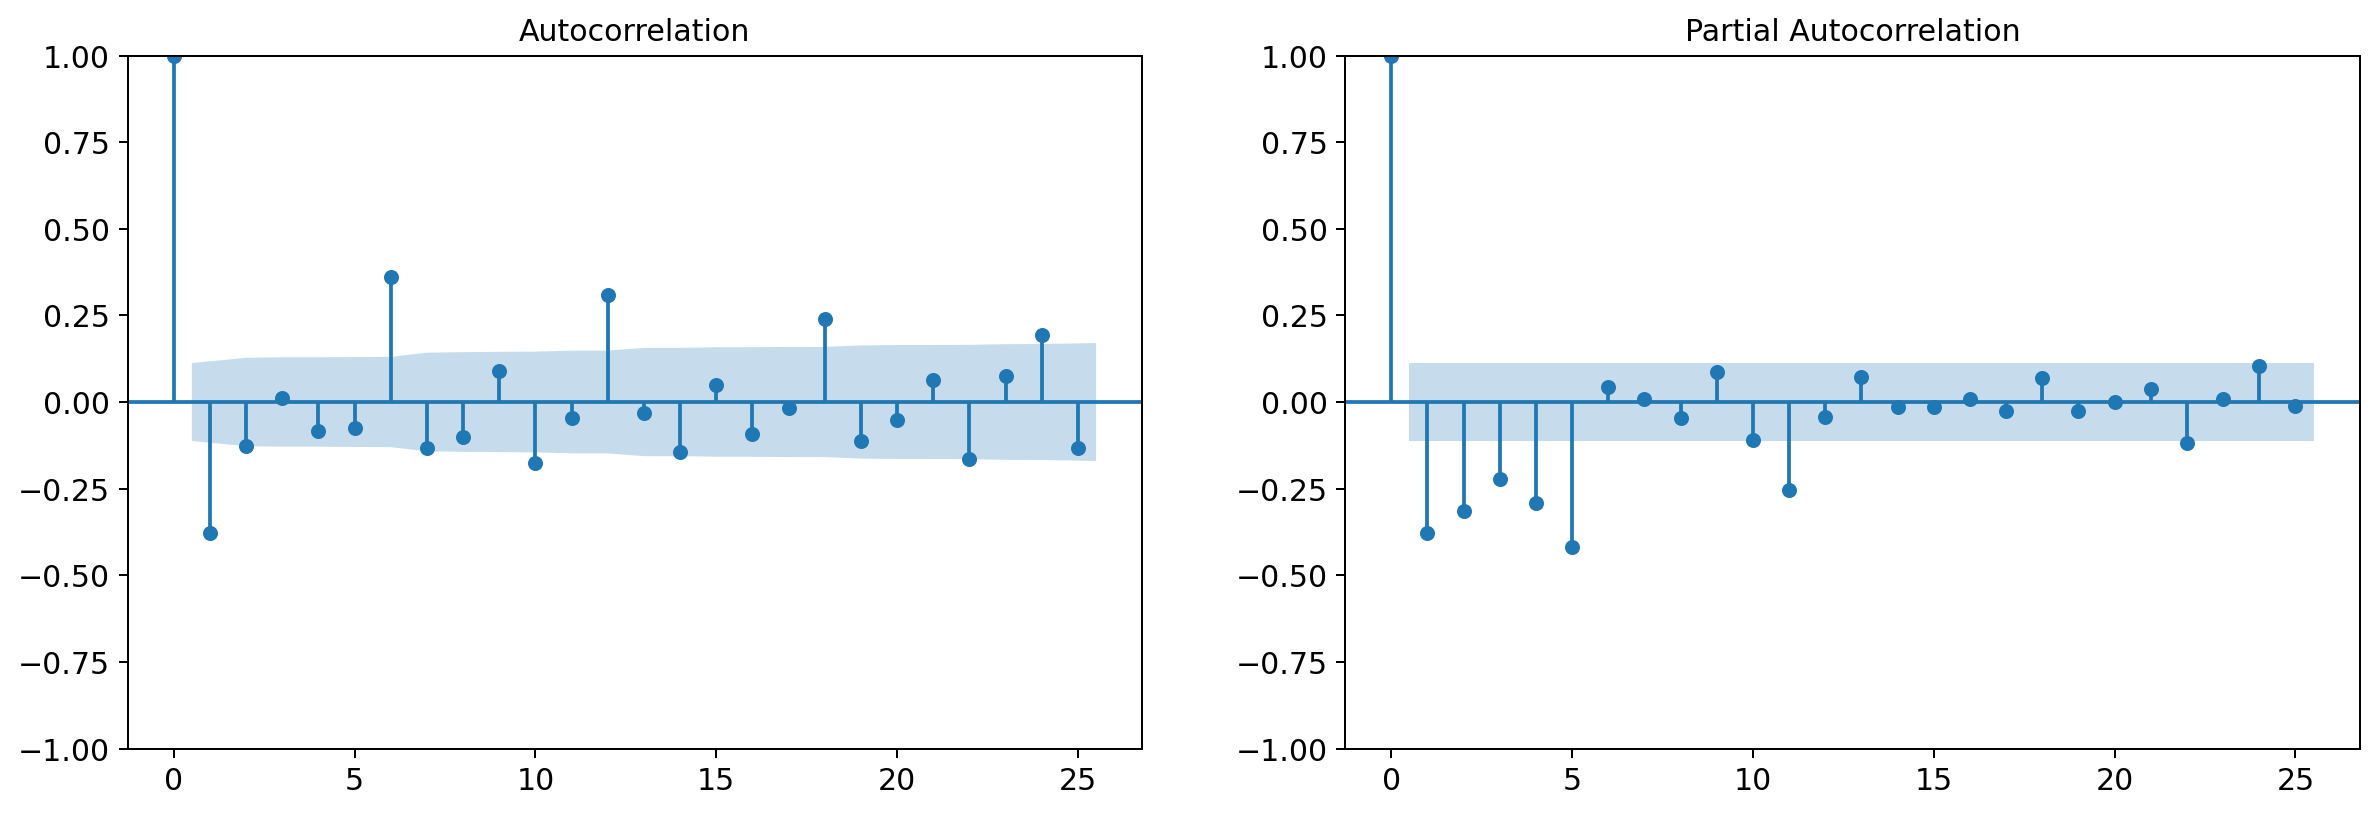

In [60]:
# visual method to determine p and q. PACF for AR and ACF for MA
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5), dpi=180)
plot_acf(day_sum_diff, ax=ax1)
plot_pacf(day_sum_diff, ax=ax2, method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()
fig.savefig('C:\\Users\\E1cal\\OneDrive\\Documents\\SQL_Notes\\PostgreSQL_Files\\E-commerce_Data\\ACF_PACF.png', bbox_inches='tight')

# Creating and Running ARIMA model using above parameters

In [10]:
# model fitting

from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

model = ARIMA(train, order=(5,1,25)).fit()
boxcox_forcast = model.forecast(len(test))
ARIMA_forecasts = inv_boxcox(boxcox_forcast, lam)

C:\Users\E1cal\anaconda3\envs\APML\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Creating and running Prophet model to compare 

In [12]:
from prophet import Prophet 

mf = pd.DataFrame({'ds' : dates_for_day_sums[:idx], 'y' : total_profit_by_day[:idx]})
ff = pd.DataFrame({'ds' : dates_for_day_sums[idx:]})

model_prophet = Prophet()
model_prophet.fit(mf)

prophet_forecast = model_prophet.predict(ff)


C:\Users\E1cal\anaconda3\envs\APML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:57:58 - cmdstanpy - INFO - Chain [1] start processing
09:57:58 - cmdstanpy - INFO - Chain [1] done processing


# Results - ARIMA vs Prophet

In [62]:
import plotly.io as pio
import plotly.graph_objects as go

pio.renderers.default = 'notebook'

def plot_forecasts(forecasts: list[float], title: list[str]) -> None:
    """function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates_for_day_sums[:idx], y=total_profit_by_day[:idx], name='Train'))
    fig.add_trace(go.Scatter(x=dates_for_day_sums[idx:], y=total_profit_by_day[idx:], name='Test'))
    for predicted_trace in range(len(forecasts)):
        fig.add_trace(go.Scatter(x=dates_for_day_sums[idx:], y=forecasts[predicted_trace], name=title[predicted_trace]+' Forecast'))
        
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Forecasts for different Models',
                      width=1080, title_x=0.5, height=720, xaxis_title='Date',
                      yaxis_title='Total Profit')
    return fig

model_forcasts = []
model_forcasts.append(ARIMA_forecasts)
model_forcasts.append(prophet_forecast['yhat'])


In [66]:
# non-linear forcast does better than linear forcast for this data.
fig = plot_forecasts(model_forcasts, ['ARIMA', 'Prophet'])
fig.show()
# fig.write_html("C:\\Users\\E1cal\\OneDrive\\Documents\\SQL_Notes\\PostgreSQL_Files\\E-commerce_Data\\Forecasts_ARIMA_Prophet.html")

# Checking ARIMA code

In [68]:
# As a check of my code, can run the above ARIMA code for a dataset that has been forcasted before
dfap = pd.read_csv("C:\\Users\\E1cal\\OneDrive\\Documents\\SQL_Notes\\PostgreSQL_Files\\E-commerce_Data\\AirPassengers.csv")
dfap['Month'] = pd.to_datetime(dfap['Month'])
dates_passengers = dfap['Month'].to_numpy()
total_passengers = dfap['#Passengers'].to_numpy()

<Figure size 640x480 with 0 Axes>

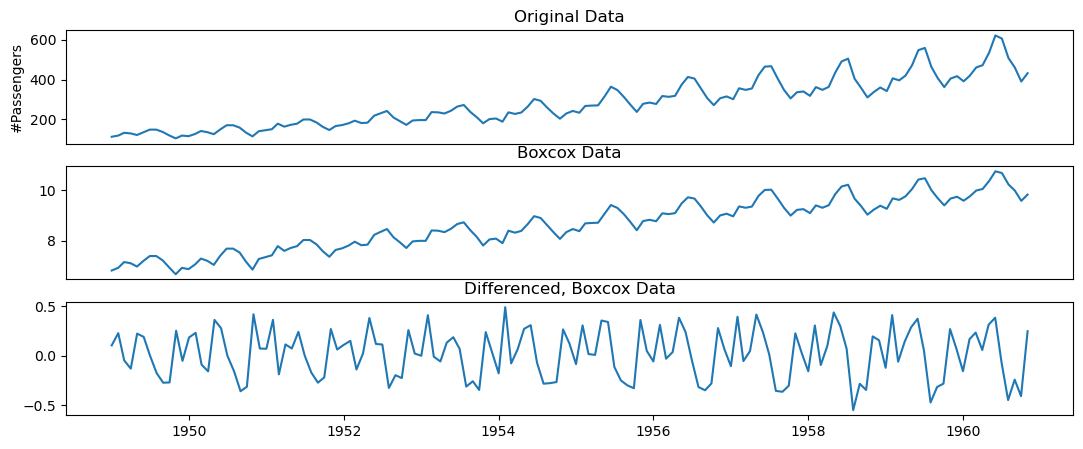

In [88]:
# imposing stationarity of variance
boxcox_passengers, lam_passengers = boxcox(total_passengers)

#plotting original versus boxcox to visualize stationarity in variance
fig = plt.figure()
figap, (axap1, axap2, axap3) = plt.subplots(3,1, figsize=(13,5))
axap1.plot(dates_passengers, total_passengers)
axap2.plot(dates_passengers, boxcox_passengers)
axap3.plot(dates_passengers[:-1], np.diff(boxcox_passengers))
#axap1.set_xlabel('Dates')
axap1.set_ylabel('#Passengers')
#axap2.set_xlabel('Dates')
axap1.set_title('Original Data')
axap2.set_title('Boxcox Data')
axap3.set_title('Differenced, Boxcox Data')
axap1.xaxis.set_visible(False)
axap1.xaxis.set_visible(False)
axap2.xaxis.set_visible(False)
#ax1.set_ylabel('Total Profit, Dollars')
#ax1.set_yticklabels([str(int(tk))+'K' for tk in ax1.get_yticks()])
plt.show()

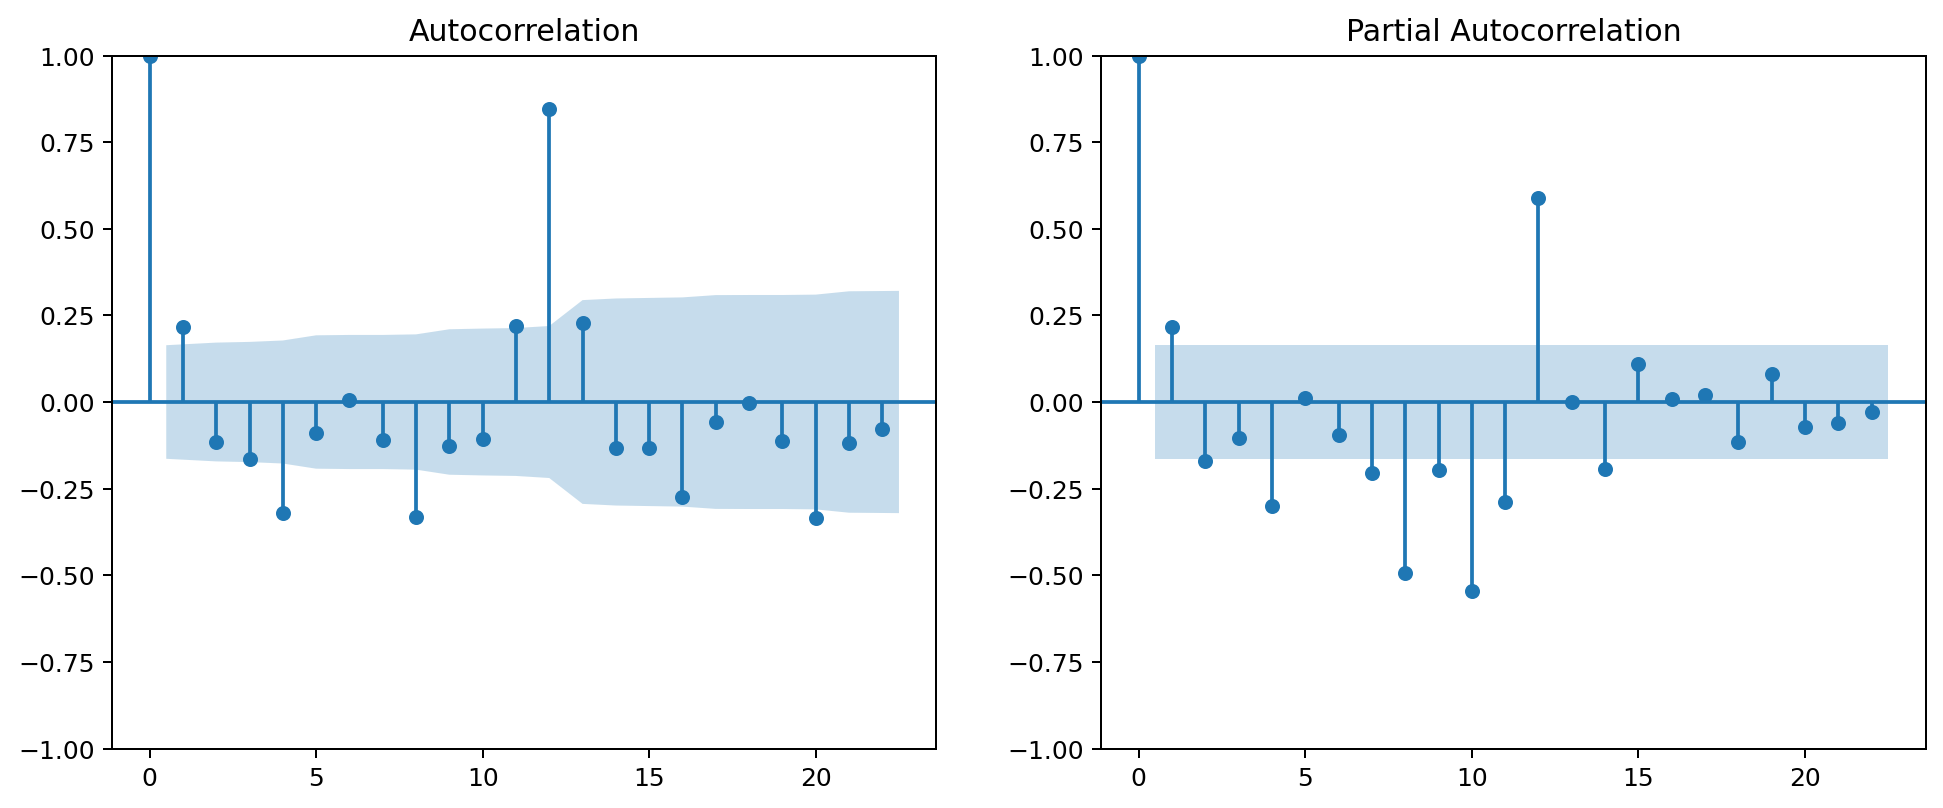

In [90]:
# take boxcox data and difference it to achieve stationarity of mean

#first spliting into training and testing data
idap = -int(len(boxcox_passengers)*0.2)
train_ap = boxcox_passengers[:idap]
test_ap = boxcox_passengers[idap:]

# differencing data
boxcox_diff = np.diff(boxcox_passengers)

fig_cf, (ax_acf, ax_pacf) = plt.subplots(1,2, figsize=(13,5), dpi=180)
plot_acf(boxcox_diff, ax=ax_acf)
plot_pacf(boxcox_diff, ax=ax_pacf, method='ywm')
plt.show()

In [92]:
model_ap = ARIMA(train_ap, order=(12,1,12)).fit()
boxcox_forcast_ap = model_ap.forecast(len(test_ap))
forecasts_ap = inv_boxcox(boxcox_forcast_ap, lam_passengers)

C:\Users\E1cal\anaconda3\envs\APML\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\E1cal\anaconda3\envs\APML\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\E1cal\anaconda3\envs\APML\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [94]:
def plot_forecasts(forecasts: list[float], title: list[str]) -> None:
    """function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates_passengers[:idap], y=total_passengers[:idap], name='Train'))
    fig.add_trace(go.Scatter(x=dates_passengers[idap:], y=total_passengers[idap:], name='Test'))
    for predicted_trace in range(len(forecasts)):
        fig.add_trace(go.Scatter(x=dates_passengers[idap:], y=forecasts[predicted_trace], name=title[predicted_trace]+' Forecast'))
        
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Air Passenger Forecasts',
                      width=1080, title_x=0.5, height=720, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig



# Results 

In [96]:
model_forecasts_ap = []
model_forecasts_ap.append(forecasts_ap)
fig = plot_forecasts(model_forecasts_ap, ['ARIMA'])
fig.show()

In [98]:
fig.write_html("C:\\Users\\E1cal\\OneDrive\\Documents\\SQL_Notes\\PostgreSQL_Files\\E-commerce_Data\\AirPassengers_Forecasts.html")